In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [2]:
def generate():
  return [
    gen_num_edges(1000, round(1000 * degree))
      for degree in np.arange(1, 2.1, 0.1) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	# Solver("kalp"),
	# Solver("brute", "BRUTE_FORCE"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(6)'

In [74]:
benchmark = Benchmark.load("../benchmarks/test(15)")

In [4]:
benchmark.run(retryFailures=True, timeout=2)


graph: 0.txt, solver: brute('FAST_BOUND') ... 

✅
length: 24, run_time: 0.000111
graph: 1.txt, solver: brute('FAST_BOUND') ... ✅
length: 66, run_time: 0.000849
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 109, run_time: 0.030349
graph: 3.txt, solver: brute('FAST_BOUND') ... ✅
length: 114, run_time: 0.030858
graph: 4.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 5.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 6.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 7.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 8.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 9.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)
graph: 10.txt, solver: brute('FAST_BOUND') ... ❌ (timeout)


In [5]:
df = benchmark.get_dataframe()
df

,path,run_time,length,solver,graph_id,failure,solver_name,vertices,edges,average_out_degree
0,"[279, 999, 813, 114, 255, 409, 894, 56, 941, 9...",0.000111,24.0,0,0,NaN,brute('FAST_BOUND'),1000,1000,1.0
1,"[52, 385, 62, 762, 780, 550, 386, 982, 591, 82...",0.000849,66.0,0,1,NaN,brute('FAST_BOUND'),1000,1100,1.1
2,"[10, 144, 330, 175, 395, 739, 850, 574, 390, 9...",0.030349,109.0,0,2,NaN,brute('FAST_BOUND'),1000,1200,1.2
3,"[427, 863, 781, 780, 651, 874, 294, 909, 417, ...",0.030858,114.0,0,3,NaN,brute('FAST_BOUND'),1000,1300,1.3
4,NaN,2.000000,NaN,0,4,timeout,brute('FAST_BOUND'),1000,1400,1.4
5,NaN,2.000000,NaN,0,5,timeout,brute('FAST_BOUND'),1000,1500,1.5
6,NaN,2.000000,NaN,0,6,timeout,brute('FAST_BOUND'),1000,1600,1.6
7,NaN,2.000000,NaN,0,7,timeout,brute('FAST_BOUND'),1000,1700,1.7
8,NaN,2.000000,NaN,0,8,timeout,brute('FAST_BOUND'),1000,1800,1.8
9,NaN,2.000000,NaN,0,9,timeout,brute('FAST_BOUND'),1000,1900,1.9


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

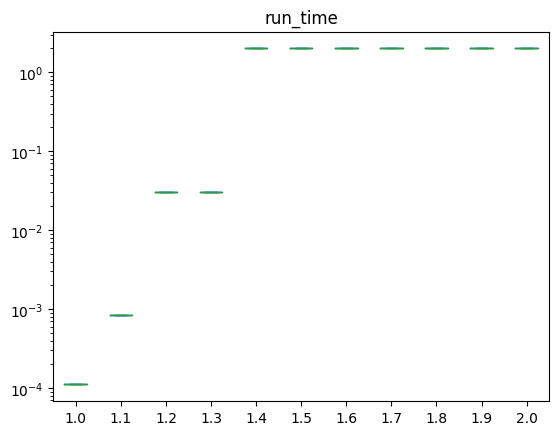

In [6]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


NameError: name 'solver_names' is not defined

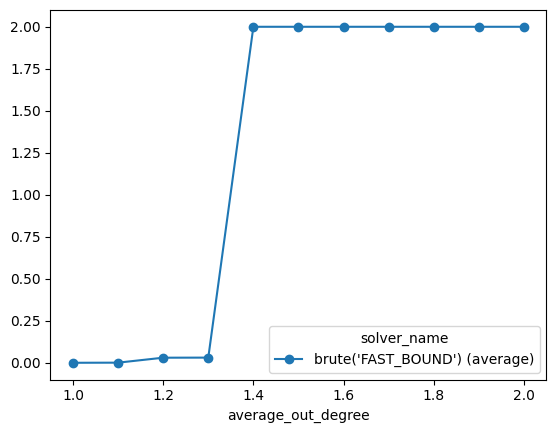

In [7]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
    .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
    .rename(columns=lambda x: x + " (average)");


to_plot.plot(style="o-")

for solver_name in solver_names:
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average out degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

In [51]:
to_plot2 = df.groupby("solver").get_group(0)[["run_time", "average_out_degree"]].sort_values(by="average_out_degree")
to_plot2


,run_time,average_out_degree
0,0.000010,1.0
1,0.000008,1.0
2,0.000012,1.0
3,0.000009,1.0
4,0.000010,1.0
...,...,...
104,0.000111,2.0
105,0.000697,2.0
106,0.001308,2.0
107,0.000577,2.0


<Axes: xlabel='average_out_degree'>

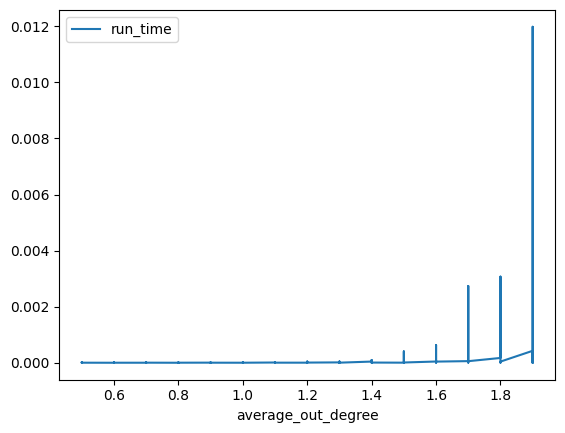

In [22]:
to_plot2.plot(x="average_out_degree", y="run_time")

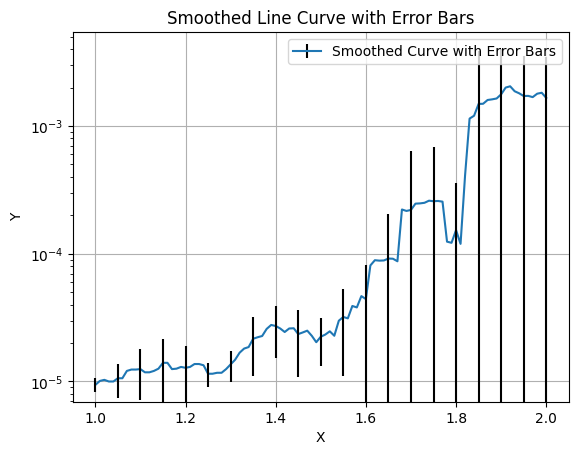

In [56]:
rolling_window = 10
df_smoothed = to_plot2.rolling(rolling_window, center=True).mean()
df_std = to_plot2.rolling(rolling_window, center=True).std()

# Plot the smoothed curve with error bars
plt.errorbar(df_smoothed['average_out_degree'], df_smoothed['run_time'], yerr=df_std['run_time'], label='Smoothed Curve with Error Bars', errorevery=5, barsabove=True, ecolor="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.yscale("log")
plt.title('Smoothed Line Curve with Error Bars')
plt.legend()
plt.grid(True)
plt.show()